The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==1.0.0-alpha0


# Long Short-Term Memory (LSTM)
:label:`sec_lstm`

The challenge to address long-term information preservation and short-term input
skipping in latent variable models has existed for a long time. One of the
earliest approaches to address this was the
long short-term memory (LSTM) :cite:`Hochreiter.Schmidhuber.1997`. It shares many of the properties of the
GRU.
Interestingly, LSTMs have a slightly more complex
design than GRUs but predates GRUs by almost two decades.



## Gated Memory Cell

Arguably LSTM's design is inspired
by logic gates of a computer.
LSTM introduces a *memory cell* (or *cell* for short)
that has the same shape as the hidden state
(some literatures consider the memory cell
as a special type of the hidden state),
engineered to record additional information.
To control the memory cell
we need a number of gates.
One gate is needed to read out the entries from the
cell.
We will refer to this as the
*output gate*.
A second gate is needed to decide when to read data into the
cell.
We refer to this as the *input gate*.
Last, we need a mechanism to reset
the content of the cell, governed by a *forget gate*.
The motivation for such a
design is the same as that of GRUs,
namely to be able to decide when to remember and
when to ignore inputs in the hidden state via a dedicated mechanism. Let's see
how this works in practice.


### Input Gate, Forget Gate, and Output Gate

Just like in GRUs,
the data feeding into the LSTM gates are
the input at the current time step and
the hidden state of the previous time step,
as illustrated in :numref:`fig_lstm_0`.
They are processed by
three fully connected layers with a sigmoid activation function to compute the values of
the input, forget, and output gates.
As a result, values of the three gates
are in the range of $(0, 1)$.

![Computing the input gate, the forget gate, and the output gate in an LSTM model.](../img/lstm-0.svg)
:label:`fig_lstm_0`

Mathematically,
suppose that there are $h$ hidden units, the batch size is $n$, and the number of inputs is $d$.
Thus, the input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ and the hidden state of the previous time step is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. Correspondingly, the gates at time step $t$
are defined as follows: the input gate is $\mathbf{I}_t \in \mathbb{R}^{n \times h}$, the forget gate is $\mathbf{F}_t \in \mathbb{R}^{n \times h}$, and the output gate is $\mathbf{O}_t \in \mathbb{R}^{n \times h}$. They are calculated as follows:

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

where $\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$ are bias parameters.

### Candidate Memory Cell

Next we design the memory cell. Since we have not specified the action of the various gates yet, we first introduce the *candidate* memory cell $\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$. Its computation is similar to that of the three gates described above, but using a $\tanh$ function with a value range for $(-1, 1)$ as the activation function. This leads to the following equation at time step $t$:

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

where $\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_c \in \mathbb{R}^{1 \times h}$ is a bias parameter.

A quick illustration of the candidate memory cell is shown in :numref:`fig_lstm_1`.

![Computing the candidate memory cell in an LSTM model.](../img/lstm-1.svg)
:label:`fig_lstm_1`

### Memory Cell

In GRUs, we have a mechanism to govern input and forgetting (or skipping).
Similarly,
in LSTMs we have two dedicated gates for such purposes: the input gate $\mathbf{I}_t$ governs how much we take new data into account via $\tilde{\mathbf{C}}_t$ and the forget gate $\mathbf{F}_t$ addresses how much of the old memory cell content $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ we retain. Using the same pointwise multiplication trick as before, we arrive at the following update equation:

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

If the forget gate is always approximately 1 and the input gate is always approximately 0, the past memory cells $\mathbf{C}_{t-1}$ will be saved over time and passed to the current time step.
This design is introduced to alleviate the vanishing gradient problem and to better capture
long range dependencies within sequences.

We thus arrive at the flow diagram in :numref:`fig_lstm_2`.

![Computing the memory cell in an LSTM model.](../img/lstm-2.svg)

:label:`fig_lstm_2`


### Hidden State

Last, we need to define how to compute the hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$. This is where the output gate comes into play. In LSTM it is simply a gated version of the $\tanh$ of the memory cell.
This ensures that the values of $\mathbf{H}_t$ are always in the interval $(-1, 1)$.

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$


Whenever the output gate approximates 1 we effectively pass all memory information through to the predictor, whereas for the output gate close to 0 we retain all the information only within the memory cell and perform no further processing.



:numref:`fig_lstm_3` has a graphical illustration of the data flow.

![Computing the hidden state in an LSTM model.](../img/lstm-3.svg)
:label:`fig_lstm_3`



## Implementation from Scratch

Now let's implement an LSTM from scratch.
As same as the experiments in :numref:`sec_rnn-scratch`,
we first load *The Time Machine* dataset.


In [1]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import rnn

npx.set_np()

### [**Initializing Model Parameters**]

Next we need to define and initialize the model parameters. As previously, the hyperparameter `num_hiddens` defines the number of hidden units. We initialize weights following a Gaussian distribution with 0.01 standard deviation, and we set the biases to 0.


In [2]:
class LSTMScratch(d2l.Module):  #@save
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: np.random.randn(*shape) * sigma
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          np.zeros(num_hiddens))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Candidate memory cell

[**The actual model**] is defined just like what we discussed before: providing three gates and an auxiliary memory cell. Note that only the hidden state is passed to the output layer. The memory cell $\mathbf{C}_t$ does not directly participate in the output computation.


In [3]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    H, C = None, None if H_C is None else H_C
    outputs = []
    for X in inputs:
        I = npx.sigmoid(np.dot(X, self.W_xi) + (
            np.dot(H, self.W_hi) if H is not None else 0) + self.b_i)
        if H is None:
            H, C = np.zeros_like(I), np.zeros_like(I)
        F = npx.sigmoid(np.dot(X, self.W_xf) +
                        np.dot(H, self.W_hf) + self.b_f)
        O = npx.sigmoid(np.dot(X, self.W_xo) +
                        np.dot(H, self.W_ho) + self.b_o)
        C_tilda = np.tanh(np.dot(X, self.W_xc) +
                           np.dot(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilda
        H = O * np.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

### [**Training**] and Prediction

Let's train an LSTM as same as what we did in :numref:`sec_gru`, by instantiating the `RNNLMScratch` class as introduced in :numref:`sec_rnn-scratch`.


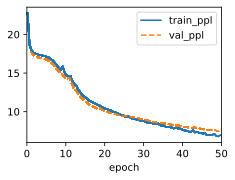

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## [**Concise Implementation**]

Using high-level APIs,
we can directly instantiate an `LSTM` model.
This encapsulates all the configuration details that we made explicit above. The code is significantly faster as it uses compiled operators rather than Python for many details that we spelled out in detail before.


In [5]:
class LSTM(d2l.RNN):
    def __init__(self, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = rnn.LSTM(num_hiddens)

    def forward(self, inputs, H_C=None):
        if H_C is None: H_C = self.rnn.begin_state(
            inputs.shape[1], ctx=inputs.ctx)
        return self.rnn(inputs, H_C)

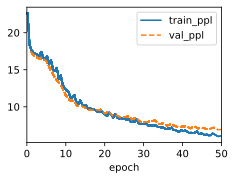

In [6]:
lstm = LSTM(num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [7]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has all the time the ti'

LSTMs are the prototypical latent variable autoregressive model with nontrivial state control.
Many variants thereof have been proposed over the years, e.g., multiple layers, residual connections, different types of regularization. However, training LSTMs and other sequence models (such as GRUs) are quite costly due to the long range dependency of the sequence.
Later we will encounter alternative models such as transformers that can be used in some cases.


## Summary

* LSTMs have three types of gates: input gates, forget gates, and output gates that control the flow of information.
* The hidden layer output of LSTM includes the hidden state and the memory cell. Only the hidden state is passed into the output layer. The memory cell is entirely internal.
* LSTMs can alleviate vanishing and exploding gradients.


## Exercises

1. Adjust the hyperparameters and analyze the their influence on running time, perplexity, and the output sequence.
1. How would you need to change the model to generate proper words as opposed to sequences of characters?
1. Compare the computational cost for GRUs, LSTMs, and regular RNNs for a given hidden dimension. Pay special attention to the training and inference cost.
1. Since the candidate memory cell ensures that the value range is between $-1$ and $1$ by  using the $\tanh$ function, why does the hidden state need to use the $\tanh$ function again to ensure that the output value range is between $-1$ and $1$?
1. Implement an LSTM model for time series prediction rather than character sequence prediction.


[Discussions](https://discuss.d2l.ai/t/343)
